In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

df = pl.read_csv("./DSU-Dataset.csv")
col = df["Date"].str.to_date()
df = df.with_columns(col)

df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,date,f64,str,i64,i64
"""A""",2018-01-01,0.0,"""BREATHING PROBLEM""",1,1
"""A""",2018-01-01,0.0,"""BURN""",1,0
"""A""",2018-01-01,0.0,"""SHAKING""",1,1
"""A""",2018-01-01,0.0,"""VOMITING""",1,0
"""A""",2018-01-01,1.0,"""FROSTBITE""",1,0


In [2]:
block_ranges = { 1: range(0, 6),
                 2: range(6, 12),
                 3: range(12, 18),
                 4: range(18, 24) }

min_date = df["Date"].min()
max_date = df["Date"].max()
begin_covid_date = df.filter(pl.col("Date").dt.year() == 2020).select(pl.col("Date")).min()
end_covid_date = df.filter(pl.col("Date").dt.year() == 2021).select(pl.col("Date")).max()


hourly_blocks_df = df.with_columns(
    pl.col("Hour").map_elements(lambda hr: next(block for block, hrs in block_ranges.items() if hr in hrs)).alias("Hour")
)
hourly_blocks_df = hourly_blocks_df.group_by(["Site", "Date", "Hour"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
hourly_blocks_df = hourly_blocks_df.sort(["Site", "Date", "Hour"])
hourly_blocks_df = hourly_blocks_df.with_columns(
    [
        pl.col("Date").dt.year().alias("Year"),
        pl.col("Date").dt.month().alias("Month"),
        pl.col("Date").dt.day().alias("Day"),
        pl.col("Date").dt.weekday().alias("Weekday"),
    ]
).drop("Date").select(["Site", "Year", "Month", "Day", "Weekday", "Hour", "ED Enc", "ED Enc Admitted"])

hourly_blocks_covid_df = hourly_blocks_df

# remove covid data
hourly_blocks_df = hourly_blocks_df.filter(pl.col("Year") != 2020).filter(pl.col("Year") != 2021)

hourly_blocks_df.head()

Site,Year,Month,Day,Weekday,Hour,ED Enc,ED Enc Admitted
str,i32,i8,i8,i8,i64,i64,i64
"""A""",2018,1,1,1,1,16,6
"""A""",2018,1,1,1,2,25,8
"""A""",2018,1,1,1,3,52,16
"""A""",2018,1,1,1,4,36,10
"""A""",2018,1,2,2,1,18,5


# Site A Random Forest Model

In [3]:
siteA_train = hourly_blocks_df.filter(pl.col("Site") == "A")
siteA_X = siteA_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteA_Y = siteA_train.select(["ED Enc", "ED Enc Admitted"])
siteA_X_train, siteA_X_test, siteA_Y_train, siteA_Y_test = train_test_split(siteA_X, siteA_Y, test_size=0.2, random_state=42)
siteA_model = RandomForestRegressor().fit(siteA_X_train, siteA_Y_train)

In [4]:
print(f"R² score of {siteA_model.score(siteA_X_test, siteA_Y_test)}")

R² score of 0.6338465590235167


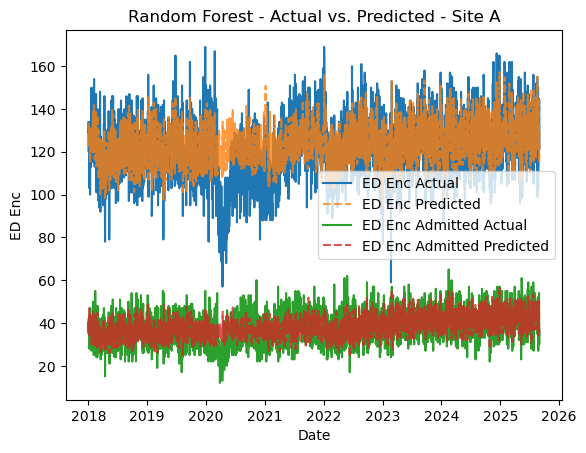

In [5]:
siteA_real = hourly_blocks_covid_df.filter(pl.col("Site") == "A")
siteA_real_X = siteA_real.select(["Year", "Month", "Day", "Weekday", "Hour"])
    
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_model.predict(siteA_real_X)
predict_df = siteA_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)
ax.set_title("Random Forest - Actual vs. Predicted - Site A")

plt.show()

# Site B Random Forest Model

In [6]:
siteB_train = hourly_blocks_df.filter(pl.col("Site") == "B")
siteB_X = siteB_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteB_Y = siteB_train.select(["ED Enc", "ED Enc Admitted"])
siteB_X_train, siteB_X_test, siteB_Y_train, siteB_Y_test = train_test_split(siteB_X, siteB_Y, test_size=0.2, random_state=42)
siteB_model = RandomForestRegressor().fit(siteB_X_train, siteB_Y_train)

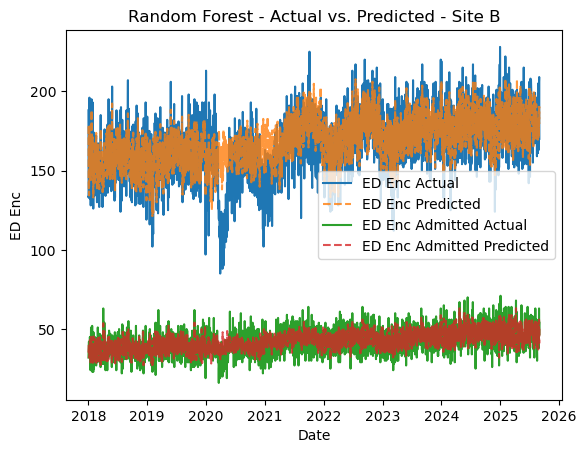

In [7]:
siteB_real = hourly_blocks_covid_df.filter(pl.col("Site") == "B")
siteB_real_X = siteB_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_model.predict(siteB_real_X)
predict_df = siteB_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random Forest - Actual vs. Predicted - Site B")
plt.show()

In [8]:
print(f"R² score of {siteB_model.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.6437023128024122


# Site C Random Forest Model

In [9]:
siteC_train = hourly_blocks_df.filter(pl.col("Site") == "C")
siteC_X = siteC_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteC_Y = siteC_train.select(["ED Enc", "ED Enc Admitted"])
siteC_X_train, siteC_X_test, siteC_Y_train, siteC_Y_test = train_test_split(siteC_X, siteC_Y, test_size=0.2, random_state=42)
siteC_model = RandomForestRegressor().fit(siteC_X_train, siteC_Y_train)

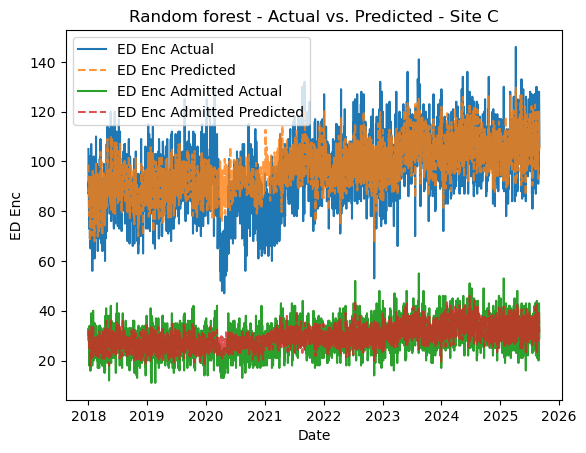

In [10]:
siteC_real = hourly_blocks_covid_df.filter(pl.col("Site") == "C")
siteC_real_X = siteC_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_model.predict(siteC_real_X)
predict_df = siteC_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random forest - Actual vs. Predicted - Site C")
plt.show()

In [11]:
print(f"R² score of {siteC_model.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.6118887125135024


# Site D Random Forest Model

In [12]:
siteD_train = hourly_blocks_df.filter(pl.col("Site") == "D")
siteD_X = siteD_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteD_Y = siteD_train.select(["ED Enc", "ED Enc Admitted"])
siteD_X_train, siteD_X_test, siteD_Y_train, siteD_Y_test = train_test_split(siteD_X, siteD_Y, test_size=0.2, random_state=42)
siteD_model = RandomForestRegressor().fit(siteD_X_train, siteD_Y_train)

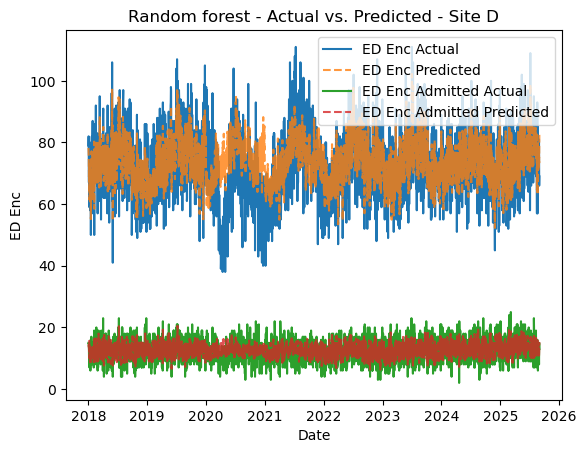

In [13]:
siteD_real = hourly_blocks_covid_df.filter(pl.col("Site") == "D")
siteD_real_X = siteD_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_model.predict(siteD_real_X)
predict_df = siteD_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random forest - Actual vs. Predicted - Site D")
plt.show()

In [14]:
print(f"R² score of {siteD_model.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.47174775061061536


# Linear regression?
We can see from the EDA that, if we take out the COVID data, the data fits pretty closely to a line for each site.

## Site A 

In [15]:
from sklearn.linear_model import LinearRegression, Ridge

siteA_linreg = Ridge(alpha=1).fit(siteA_X_train, siteA_Y_train)
score = siteA_linreg.score(siteA_X_test, siteA_Y_test)
print(f"Ridge Regression R² score of {score}")

Ridge Regression R² score of 0.44831178406277344


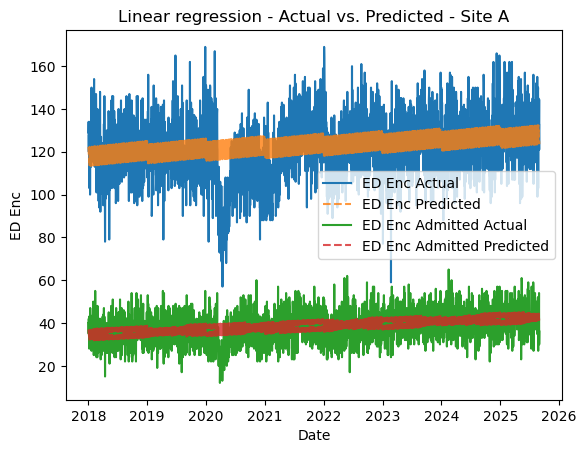

In [16]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_linreg.predict(siteA_real_X)
predict_df = siteA_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site A")
plt.show()

## Site B

In [17]:
siteB_linreg = Ridge().fit(siteB_X_train, siteB_Y_train)
print(f"R² score of {siteB_linreg.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.5246460075832075


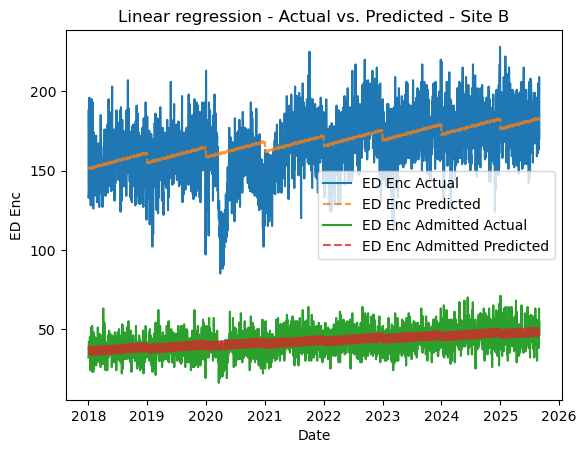

In [18]:
plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_linreg.predict(siteB_real_X)
predict_df = siteB_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site B")
plt.show()

## Site C

In [19]:
siteC_linreg = LinearRegression().fit(siteC_X_train, siteC_Y_train)
print(f"R² score of {siteC_linreg.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.41803995754888


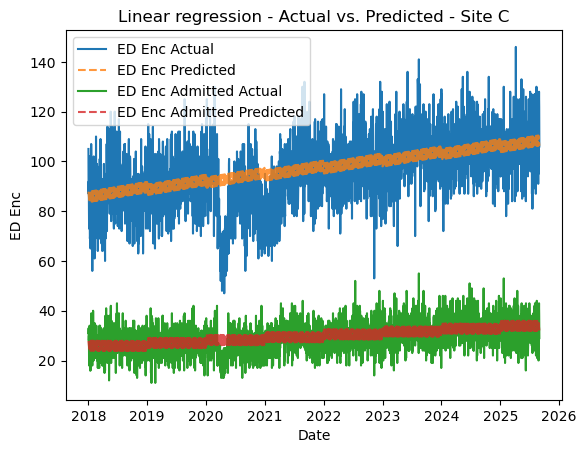

In [20]:
plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_linreg.predict(siteC_real_X)
predict_df = siteC_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site C")
plt.show()

## Site D

In [21]:
siteD_linreg = LinearRegression().fit(siteD_X_train, siteD_Y_train)
print(f"R² score of {siteD_linreg.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.2842632788124213


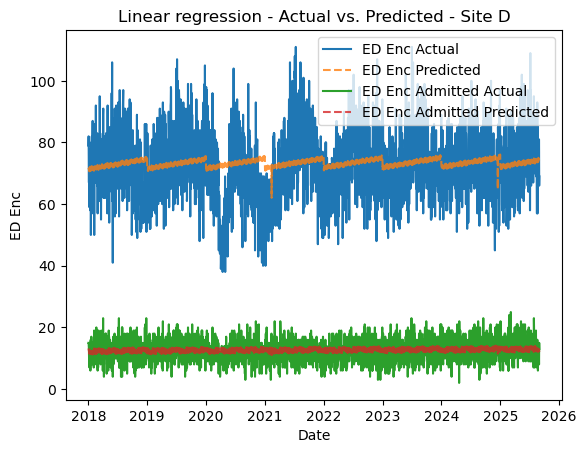

In [22]:
plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_linreg.predict(siteD_real_X)
predict_df = siteD_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site D")
plt.show()

# CATboost?
Gradient boosted trees

In [23]:
from catboost import CatBoostRegressor, Pool
siteA_train_pool = Pool(siteA_X_train.to_pandas(), siteA_Y_train.to_pandas(), cat_features=siteA_X.columns)
siteA_test_pool = Pool(siteA_X_test.to_pandas(), siteA_Y_test.to_pandas(), cat_features=siteA_X.columns)

siteA_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteA_catmodel.fit(siteA_train_pool)

print(f"R² score of {siteA_catmodel.score(siteA_test_pool)}")

0:	learn: 12.3217568	total: 186ms	remaining: 3m 5s
1:	learn: 11.5069669	total: 211ms	remaining: 1m 45s
2:	learn: 10.8028442	total: 246ms	remaining: 1m 21s
3:	learn: 10.1875970	total: 286ms	remaining: 1m 11s
4:	learn: 9.6871008	total: 325ms	remaining: 1m 4s
5:	learn: 9.2332199	total: 362ms	remaining: 1m
6:	learn: 8.8530527	total: 389ms	remaining: 55.1s
7:	learn: 8.5200892	total: 427ms	remaining: 52.9s
8:	learn: 8.2409481	total: 464ms	remaining: 51s
9:	learn: 8.0111158	total: 503ms	remaining: 49.8s
10:	learn: 7.8321473	total: 527ms	remaining: 47.4s
11:	learn: 7.6738652	total: 563ms	remaining: 46.3s
12:	learn: 7.5337393	total: 595ms	remaining: 45.2s
13:	learn: 7.4100242	total: 636ms	remaining: 44.8s
14:	learn: 7.3041924	total: 676ms	remaining: 44.4s
15:	learn: 7.2310551	total: 701ms	remaining: 43.1s
16:	learn: 7.1737082	total: 721ms	remaining: 41.7s
17:	learn: 7.1070677	total: 761ms	remaining: 41.5s
18:	learn: 7.0674360	total: 786ms	remaining: 40.6s
19:	learn: 7.0169831	total: 826ms	remai

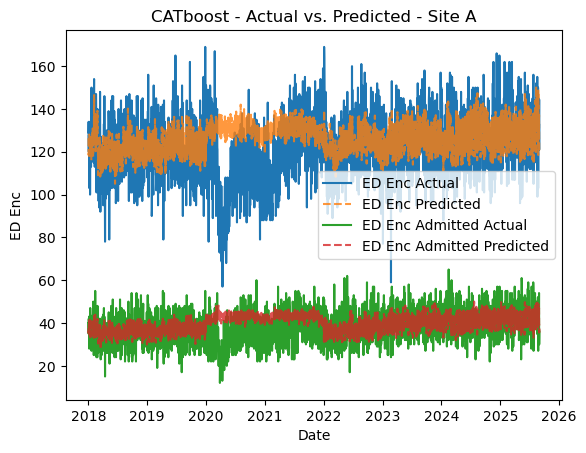

In [24]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_catmodel.predict(siteA_real_X.to_pandas())
predict_df = siteA_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site A")
plt.show()

In [25]:
siteB_train_pool = Pool(siteB_X_train.to_pandas(), siteB_Y_train.to_pandas(), cat_features=siteB_X.columns)
siteB_test_pool = Pool(siteB_X_test.to_pandas(), siteB_Y_test.to_pandas(), cat_features=siteB_X.columns)

siteB_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteB_catmodel.fit(siteB_train_pool)

print(f"R² score of {siteB_catmodel.score(siteB_test_pool)}")

0:	learn: 15.4809831	total: 34.7ms	remaining: 34.6s
1:	learn: 14.4170943	total: 80.4ms	remaining: 40.1s
2:	learn: 13.4987138	total: 107ms	remaining: 35.7s
3:	learn: 12.6557389	total: 150ms	remaining: 37.4s
4:	learn: 11.9461534	total: 192ms	remaining: 38.1s
5:	learn: 11.3604888	total: 212ms	remaining: 35.2s
6:	learn: 10.8682259	total: 243ms	remaining: 34.5s
7:	learn: 10.4256845	total: 275ms	remaining: 34.2s
8:	learn: 10.0420305	total: 321ms	remaining: 35.3s
9:	learn: 9.7211800	total: 362ms	remaining: 35.9s
10:	learn: 9.4183142	total: 404ms	remaining: 36.3s
11:	learn: 9.1685981	total: 446ms	remaining: 36.7s
12:	learn: 8.9545818	total: 487ms	remaining: 37s
13:	learn: 8.8076488	total: 507ms	remaining: 35.7s
14:	learn: 8.6479039	total: 547ms	remaining: 35.9s
15:	learn: 8.5404792	total: 581ms	remaining: 35.7s
16:	learn: 8.4373648	total: 626ms	remaining: 36.2s
17:	learn: 8.3560449	total: 666ms	remaining: 36.3s
18:	learn: 8.2778084	total: 709ms	remaining: 36.6s
19:	learn: 8.2127563	total: 749m

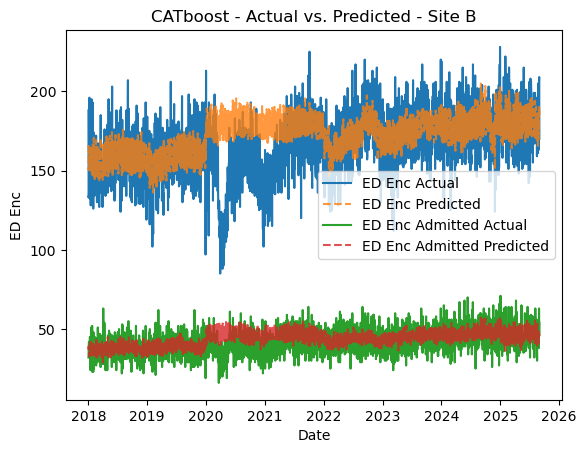

In [26]:
plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_catmodel.predict(siteB_real_X.to_pandas())
predict_df = siteB_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site B")
plt.show()

In [27]:
siteC_train_pool = Pool(siteC_X_train.to_pandas(), siteC_Y_train.to_pandas(), cat_features=siteC_X.columns)
siteC_test_pool = Pool(siteC_X_test.to_pandas(), siteC_Y_test.to_pandas(), cat_features=siteC_X.columns)

siteC_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteC_catmodel.fit(siteC_train_pool)

print(f"R² score of {siteC_catmodel.score(siteC_test_pool)}")

0:	learn: 10.4947379	total: 36.1ms	remaining: 36.1s
1:	learn: 9.8139953	total: 80.9ms	remaining: 40.4s
2:	learn: 9.2248420	total: 123ms	remaining: 41s
3:	learn: 8.7211428	total: 167ms	remaining: 41.5s
4:	learn: 8.2909703	total: 216ms	remaining: 42.9s
5:	learn: 7.9232963	total: 264ms	remaining: 43.7s
6:	learn: 7.6250773	total: 309ms	remaining: 43.9s
7:	learn: 7.3728040	total: 352ms	remaining: 43.6s
8:	learn: 7.1416281	total: 394ms	remaining: 43.4s
9:	learn: 6.9550874	total: 437ms	remaining: 43.3s
10:	learn: 6.7845702	total: 481ms	remaining: 43.2s
11:	learn: 6.6377921	total: 524ms	remaining: 43.1s
12:	learn: 6.5282548	total: 558ms	remaining: 42.4s
13:	learn: 6.4244403	total: 604ms	remaining: 42.5s
14:	learn: 6.3470597	total: 648ms	remaining: 42.6s
15:	learn: 6.2786226	total: 694ms	remaining: 42.7s
16:	learn: 6.2174559	total: 740ms	remaining: 42.8s
17:	learn: 6.1652399	total: 785ms	remaining: 42.8s
18:	learn: 6.1172725	total: 829ms	remaining: 42.8s
19:	learn: 6.0861578	total: 873ms	remain

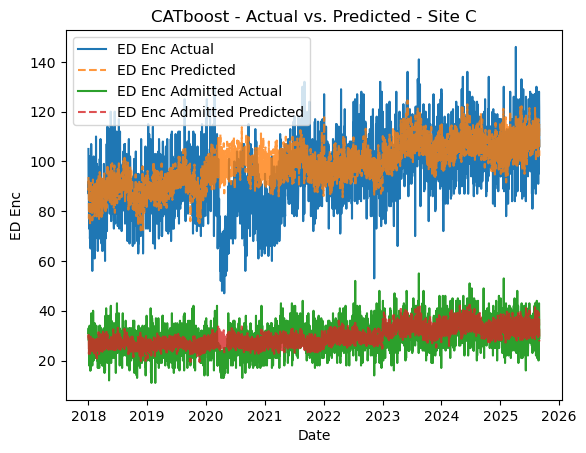

In [28]:
plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_catmodel.predict(siteC_real_X.to_pandas())
predict_df = siteC_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site C")
plt.show()

In [29]:
siteD_train_pool = Pool(siteD_X_train.to_pandas(), siteD_Y_train.to_pandas(), cat_features=siteD_X.columns)
siteD_test_pool = Pool(siteD_X_test.to_pandas(), siteD_Y_test.to_pandas(), cat_features=siteD_X.columns)

siteD_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteD_catmodel.fit(siteD_train_pool)

print(f"R² score of {siteD_catmodel.score(siteD_test_pool)}")

0:	learn: 8.1849157	total: 39ms	remaining: 38.9s
1:	learn: 7.6883789	total: 78.8ms	remaining: 39.3s
2:	learn: 7.2609076	total: 122ms	remaining: 40.7s
3:	learn: 6.8953230	total: 168ms	remaining: 41.9s
4:	learn: 6.5845220	total: 205ms	remaining: 40.8s
5:	learn: 6.3212328	total: 241ms	remaining: 40s
6:	learn: 6.1096913	total: 264ms	remaining: 37.5s
7:	learn: 5.9202003	total: 309ms	remaining: 38.4s
8:	learn: 5.7632593	total: 348ms	remaining: 38.3s
9:	learn: 5.6324732	total: 395ms	remaining: 39.1s
10:	learn: 5.5138129	total: 441ms	remaining: 39.6s
11:	learn: 5.4126313	total: 489ms	remaining: 40.2s
12:	learn: 5.3313168	total: 546ms	remaining: 41.4s
13:	learn: 5.2675155	total: 589ms	remaining: 41.5s
14:	learn: 5.2201128	total: 635ms	remaining: 41.7s
15:	learn: 5.1694987	total: 681ms	remaining: 41.9s
16:	learn: 5.1388819	total: 705ms	remaining: 40.7s
17:	learn: 5.1069291	total: 756ms	remaining: 41.3s
18:	learn: 5.0764606	total: 804ms	remaining: 41.5s
19:	learn: 5.0516291	total: 848ms	remaining

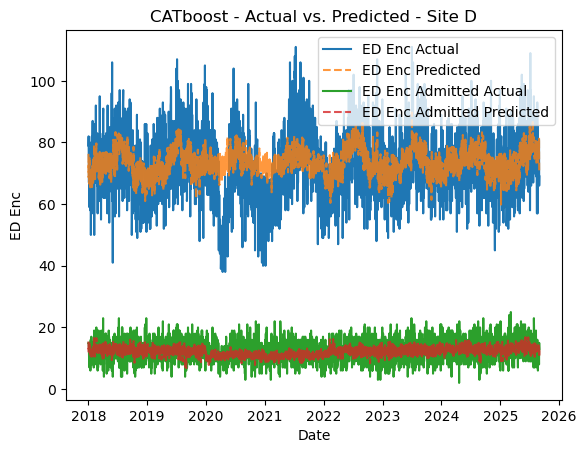

In [30]:
plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_catmodel.predict(siteD_real_X.to_pandas())
predict_df = siteD_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site D")
plt.show()

# ARIMA model
A popular model in forecasting time series data

In [31]:
daily_pandas_df = df.group_by(["Site", "Date"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum()).to_pandas().set_index("Date")
daily_pandas_df

,Site,ED Enc,ED Enc Admitted
Date,,,
2021-05-27,A,98,25
2022-09-24,A,111,32
2024-10-05,B,185,44
2024-11-16,B,177,47
2022-01-08,C,95,25
...,...,...,...
2025-02-27,D,85,12
2025-05-06,D,80,13
2025-07-05,D,91,11


In [32]:
import pmdarima as pm

siteA_data = daily_pandas_df.loc[daily_pandas_df["Site"] == "A"].drop("Site", axis=1)
model = pm.auto_arima(siteA_data["ED Enc"], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=23196.541, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=22983.378, Time=1.56 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=23041.508, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=34861.795, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=22984.675, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=22985.168, Time=8.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=22991.509, Time=3.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=22982.275, Time=0.41 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=22983.653, Time=1.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=7.97 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=23183.343, Time=0.43 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=22874.474, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=22875.125, Time=0.16 sec
 ARIMA(2,0,0)(1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2800
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -11415.671
Date:                Wed, 04 Feb 2026   AIC                          22845.343
Time:                        09:19:21   BIC                          22886.904
Sample:                             0   HQIC                         22860.345
                               - 2800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     58.6129      3.470     16.892      0.000      51.812      65.414
ar.L1          0.1920      0.017     10.982      0.000       0.158       0.226
ar.L2          0.1656      0.019      8.735      0.000       0.128       0.203
ar.L3          0.0747      0.019      3.887      0.000       0.037       0.112
ar.L4          0.0495      0.019      2.603      0.009       0.012       0.087
ar.L5          0.0350      0.019      1.886      0.059      -0.001       0.071
sigma2       203.6140      5.108     39.859      0.000     193.602     213.626
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.47
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.06
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
from pmdarima import model_selection

model_cv_scores = model_selection.cross_val_score(
    model, siteA_data["ED Enc"], scoring="mean_squared_error"
)

print(f"Model CV Scores: {model_cv_scores.tolist()}")
print(f"Average mean squared error: {model_cv_scores.mean()}")

c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

Model CV Scores: [12.381072900706451, 1593.6335493542767, 42.07681510292549, 61.50954856376501, 3.5460669540914043, 190.65928665443187, 14.570881124229997, 266.9621087564909, 145.47809313549922, 45.531759734869325, 44.39220576192487, 0.7923288174112136, 155.82403913809367, 0.050704548644527746, 58.69157174324184, 14.778093082937305, 1089.3961740316518, 2.286422412665394, 93.21886069278625, 554.0815633760129, 229.5365601995421, 94.2882720951391, 141.62879719306773, 556.0197299067136, 365.9089552997664, 22.577596591977816, 134.94011114125337, 158.34465299844646, 11.129003134134967, 91.47116028559084, 43.12422145414183, 60.339865423266765, 837.0261320130196, 86.02062393762967, 552.754703396445, 36.51067297773321, 421.2434754925878, 108.91533829482577, 19.780361649632553, 233.99931468455608, 261.03258955720247, 28.56816954600427, 84.1621992360862, 744.2327192019796, 128.42074334093064, 104.90886787613185, 24.604363164915753, 649.4359846290592, 77.57768865419816, 121.15872980295144, 756.363

c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [58]:
date_range = pl.date_range(start=df["Date"].min(), end=df["Date"].max(), eager=True)

In [53]:
siteA_real_X.shape

(11200, 5)

In [55]:
predict

2800    122.225358
2801    121.642365
2802    121.898174
2803    121.429091
2804    121.372060
           ...    
5595    121.284111
5596    121.284111
5597    121.284111
5598    121.284111
5599    121.284111
Length: 2800, dtype: float64

c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


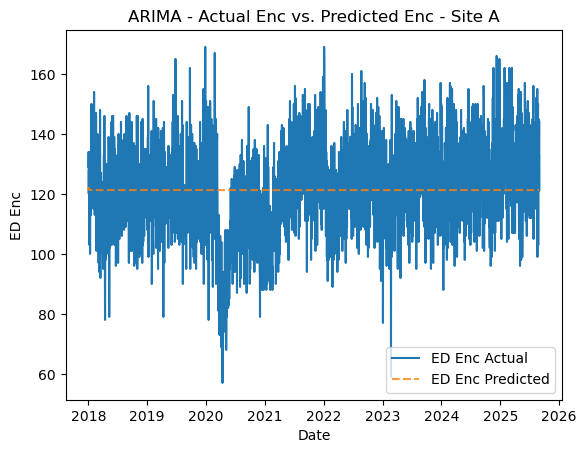

In [69]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = model.predict(n_periods=len(date_range))
predict_df = pl.DataFrame([date_range.alias("Date")]).with_columns(
    pl.Series(name="ED Enc Predicted", values=predict.tolist()),
    pl.Series(name="ED Enc Admitted Predicted", values=predict.tolist())
)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("ARIMA - Actual Enc vs. Predicted Enc - Site A")
plt.show()